In [1]:
import os
from tqdm.auto import tqdm
import re

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import gpxpy
import folium
import fiona
import shapely
from shapely.geometry import MultiLineString
from haversine import haversine
import calmap

In [2]:
directory = ''
os.chdir(path=directory)

# Extract numeric value from filename
def extract_numeric(filename):
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def factorDimensions(total, max_diff=10):
    # Find closest factors of total, if factors farther apart than max_diff, return nearest square root
    root = int(total**0.5)
    for i in range(root, 0, -1):
        if total % i == 0:
            rows, cols = i, total // i
            break
    else:
        # If no factors are found (should not happen for positive integer inputs)
        rows, cols = 1, total

    # Check if the factors are close enough)
    if abs(rows - cols) <= max_diff:
        return rows, cols
    
    # If factors are too far apart, find the nearest perfect square
    nearest_square_root = math.ceil(total**0.5)
    return nearest_square_root, nearest_square_root

# Function to calculate total distance
def calculate_distance(points):
    total_distance = 0
    for i in range(1, len(points)):
        start = (points[i-1].latitude, points[i-1].longitude)
        end = (points[i].latitude, points[i].longitude)
        total_distance += haversine(start, end) * 0.621371
    return total_distance

# Function to extract the date and distance from a GPX file
def extract_date_distance(gpx):
            
    # Extract the date from the first point (assuming all points share the same date)
    first_point_time = gpx.tracks[0].segments[0].points[0].time
    gpx_date = first_point_time.date() if first_point_time else None
    
    # Calculate the total distance for the entire track
    gpx_points = gpx.tracks[0].segments[0].points
    total_distance = calculate_distance(gpx_points)
    
    return gpx_date, total_distance

In [3]:
# Sort file names numerically
sorted_files = sorted(os.listdir(), key=extract_numeric)

dimensions = factorDimensions(len(sorted_files))

# Grid dimensions for plots with subplots
n_rows = dimensions[0]
n_cols = dimensions[1] 

activity_colors={'running': '#fc4c02',
                 'cycling': '#00aa94',
                 'hiking': '#c860df',
                 'NordicSki': '#0090ff',
                 'AlpineSki': '#0060f5'}

gpx_list = []
for file in tqdm(sorted_files):
    gpx = gpxpy.parse(open(file))
    gpx_list.append(gpx)
print(f'GPX Import Complete: {len(gpx_list)} Tracks')

fiona_tracks = []
for file in tqdm(sorted_files):
    with fiona.open(file, "r", layer="tracks") as records:
        track = [shapely.geometry.shape(record["geometry"]) for record in records]
        fiona_tracks.append(track)
print(f'Fiona Import Complete: {len(fiona_tracks)} Tracks')


GPX Import Complete: 223 Tracks



Fiona Import Complete: 223 Tracks


In [4]:
# Calculate distances and elevations
distances = []
elevations = []

for i, gpx in tqdm(enumerate(gpx_list), total=len(gpx_list)):
    gpx_data = gpx.tracks[0].segments[0].points[::10]
    
    latitude = [point.latitude for point in gpx_data]
    longitude = [point.longitude for point in gpx_data]
    
    # Calculate cumulative distance
    cum_distances = [0]
    for i in range(1, len(gpx_data)):
        distance = haversine(
            (latitude[i-1], longitude[i-1]),
            (latitude[i], longitude[i])
        )
        cum_distances.append(cum_distances[-1] + distance)  # Cumulative distance
    distances.append(cum_distances)
    
    elevation = [point.elevation for point in gpx_data]
    elevations.append(elevation)

In [5]:
### HEATMAP
m = folium.Map(tiles="Cartodb dark_matter")

for gpx in tqdm(gpx_list):
    points = []
    for track in gpx.tracks:
        for segment in track.segments:
            step = 10
            for point in segment.points[::step]:
                points.append(tuple([point.latitude, point.longitude]))

    folium.PolyLine(points,
                    color=activity_colors[track.type],
                    opacity=0.5).add_to(m)
    
m.fit_bounds(m.get_bounds())
m.save('../figures/heatmap.html')


Multilines Extraction Complete: 223 Multilines


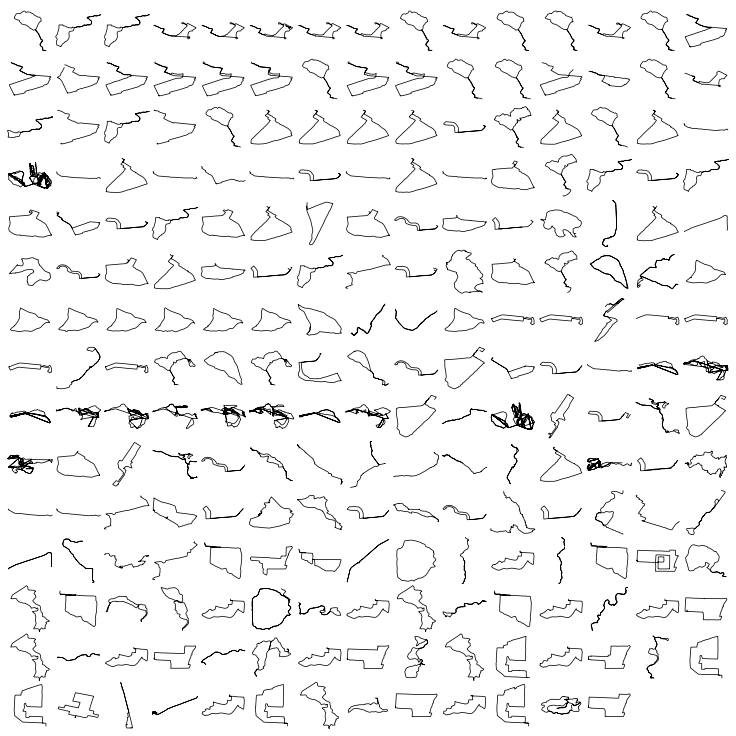

In [6]:
### TRACK GRID
multilines = [ml[0] for ml in tqdm(fiona_tracks)]
print(f'Multilines Extraction Complete: {len(multilines)} Multilines')

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*.67, n_rows*.67))
axes = axes.flatten()

for i, multi_line in tqdm(enumerate(multilines), total=len(fiona_tracks)):
    ax = axes[i]
    
    for line in multi_line.geoms:
        x, y = line.xy
        ax.plot(x, y, color='black', lw=0.75)
    
    minx, miny, maxx, maxy = multi_line.bounds
    ax.set_xlim(minx - 0.001, maxx + 0.001)
    ax.set_ylim(miny - 0.001, maxy + 0.001)
    
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[:].set_visible(False)
       
for j in range(len(multilines), len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.1, w_pad=0.25, h_pad=0.1)
plt.savefig('../figures/tracks.png', format='png', dpi=300, transparent=True)
plt.show()

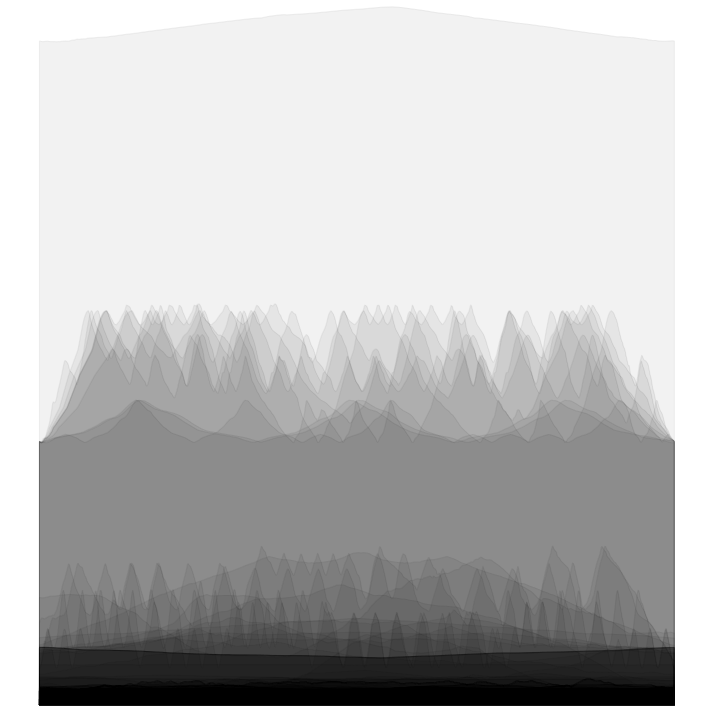

In [7]:
### ELEVATION OVERLAY

num_points = 1000
x_values = np.linspace(0, 1, num_points)

max_elevation = max(max(point.elevation for point in gpx.tracks[0].segments[0].points[::10]) for gpx in gpx_list)

plt.figure(figsize=(10,10))

for i, gpx in tqdm(enumerate(gpx_list), total=len(gpx_list)):
    distance = distances[i]
   
    # Normalize the distances to fit the X-axis (from 0 to 1)
    scaled_distances = [d / distance[-1] for d in distance]
    # Interpolate the elevations over a fixed number of points
    interpolated_elevations = np.interp(x_values, scaled_distances, elevations[i])

    plt.plot(x_values, interpolated_elevations, color='black', linestyle='-', linewidth=0.1, alpha=0.1)
    plt.fill_between(x_values, 0, interpolated_elevations, color='black', alpha=0.05)

plt.ylim(0, max_elevation)
plt.grid(False)

plt.xticks([])
plt.yticks([]) 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig('../figures/elevation_overlay.png', format='png', dpi=300, transparent=True)
plt.show()

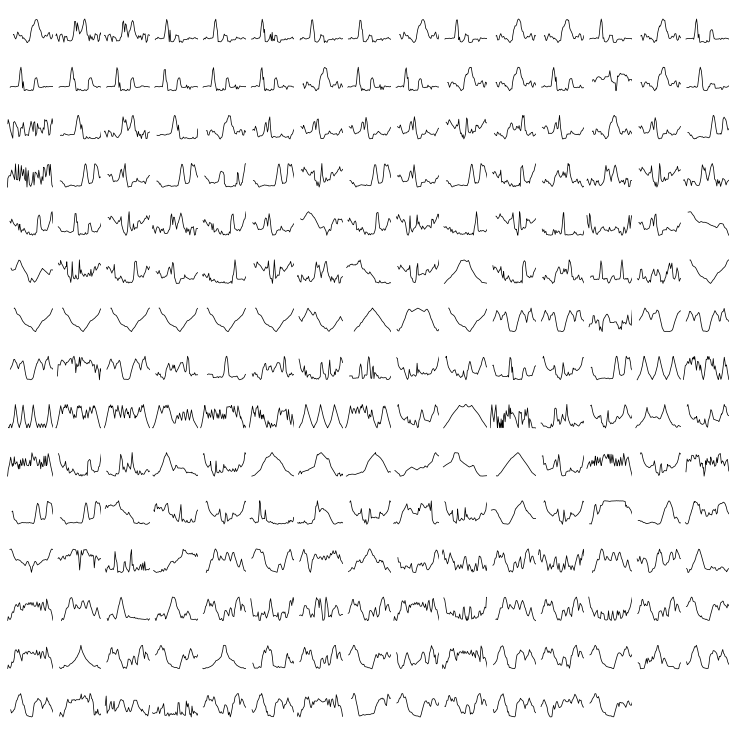

In [8]:
### ELEVATION GRID
max_points = 50

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*0.67, n_rows*0.67))
axes = axes.flatten()

for i, gpx in tqdm(enumerate(gpx_list), total=len(gpx_list)):
    ax = axes[i]
    
    distance = distances[i]
    elevation = elevations[i]
    
    norm_elevations = [(elev - min(elevation)) / (max(elevation) - min(elevation)) for elev in elevation]
    
    # Downsample if there are more than max_points for better visualization
    if len(distance) > max_points:
        indices = np.linspace(0, len(distance) - 1, max_points).astype(int)
        distance = [distance[idx] for idx in indices]
        norm_elevations = [norm_elevations[idx] for idx in indices]
    
    ax.plot(distance, norm_elevations, color='black', lw=0.75)
        
    ax.set_xlim(-0.5, distance[-1])
    ax.set_ylim(-0.5, 1.5)
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[:].set_visible(False)

for j in range(len(multilines), len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=0.1, w_pad=0.25, h_pad=0.1)
plt.savefig('../figures/elevation_grid.png', format='png', dpi=300, transparent=True)
plt.show()

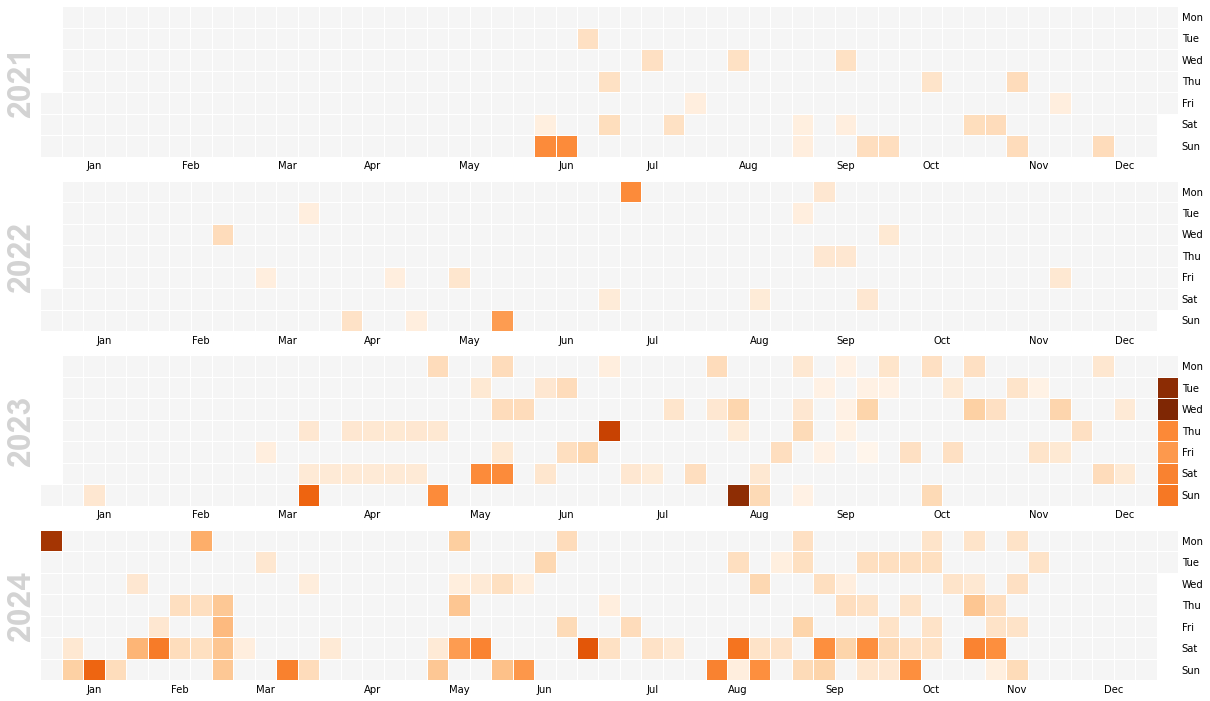

In [9]:
dates = []
distances = []

for gpx in tqdm(gpx_list): 
    gpx_date, total_distance = extract_date_distance(gpx)
    dates.append(gpx_date)
    distances.append(total_distance)

dates = pd.to_datetime(dates)

date_distance_series = pd.Series(data=distances, index=dates)

calendar = calmap.calendarplot(np.log1p(date_distance_series), cmap=plt.cm.Oranges, 
                               fig_kws=dict(figsize=(20, 10)), yearlabel_kws={'color': 'lightgray'})
calendar[0].savefig('../figures/activity_calendar.png', format='png', dpi=300, transparent=True)

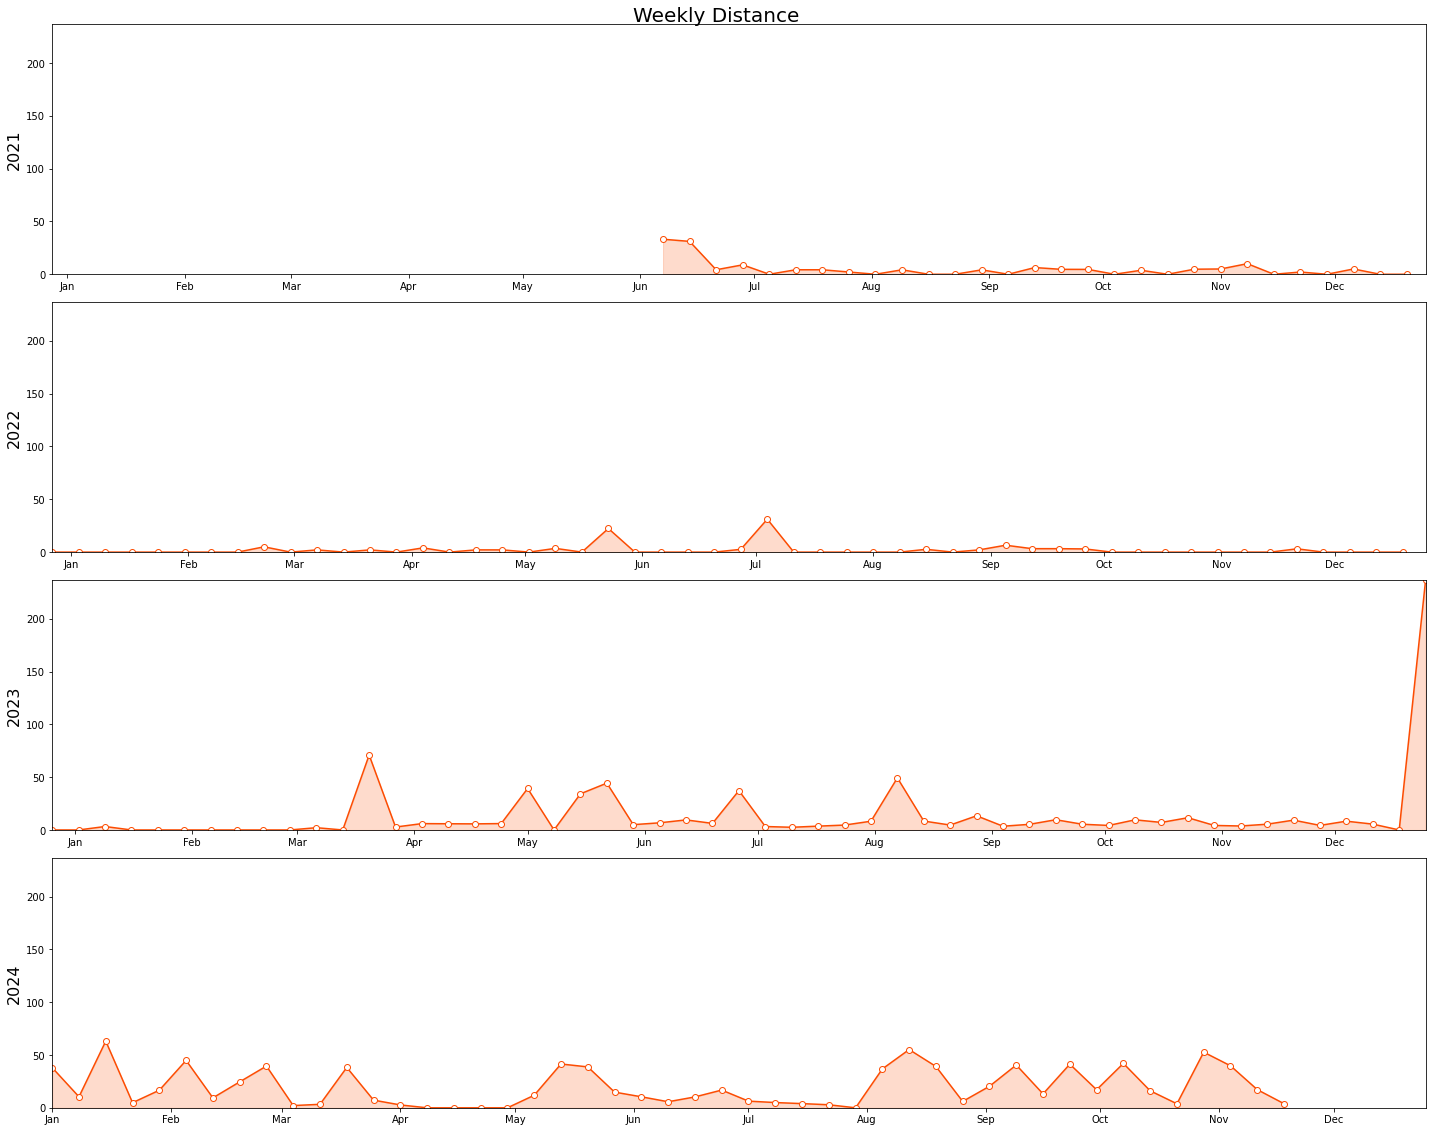

In [10]:
### WEEKLY MILES

weekly_data = date_distance_series.resample('W').sum()
years = weekly_data.index.year.unique()
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(20, 16), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    
    full_year_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='W-SUN')
    year_data = weekly_data[weekly_data.index.year == year].reindex(full_year_range)
    
    ax.plot(year_data.index, year_data.values, color='#fc4c02', marker='o', markerfacecolor='white', label=f"{year}")
    ax.fill_between(year_data.index, 0, year_data.values, where=~year_data.isna(), color='#fc4c02', alpha=0.2)
    
    ax.set_xlim(pd.Timestamp(min(year_data.index)), pd.Timestamp(f'{year}-12-31'))
    ax.set_ylim(0, max(weekly_data.values))
    ax.set_ylabel(year, fontsize=16)
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Weekly Distance', fontsize=20)
plt.tight_layout()
plt.savefig('../figures/weekly_distance.png', format='png', dpi=100, transparent=True)  # Adjust DPI for resolution
plt.show()


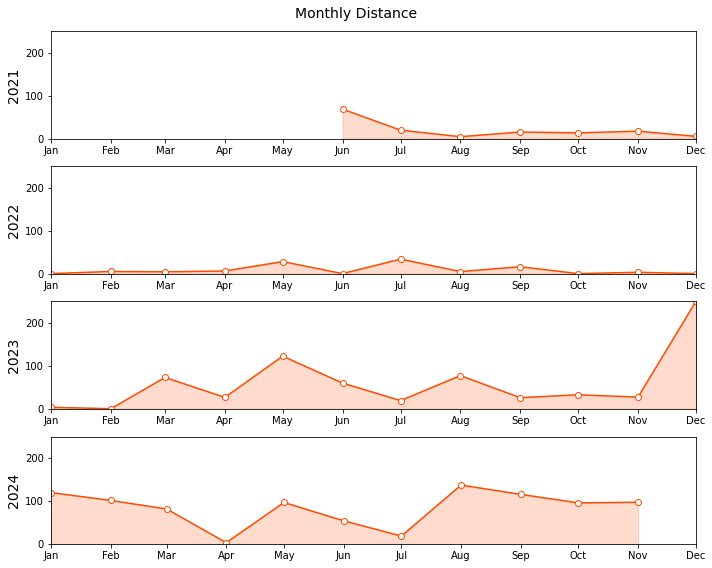

In [11]:
### MONTHLY MILES

monthly_data = date_distance_series.resample('M').sum()
years = monthly_data.index.year.unique()
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 8), sharey=True)

for i, year in enumerate(years):
    ax = axes[i]
    
    year_data = monthly_data[monthly_data.index.year == year]
    year_data.index = year_data.index.to_period('M').to_timestamp()
    
    ax.plot(year_data.index, year_data.values, color='#fc4c02', label=f"{year}", marker='o', markerfacecolor='white')
    ax.fill_between(year_data.index, 0, year_data.values, color='#fc4c02', alpha=0.2)
    
    ax.set_xlim(pd.Timestamp(f'{year}-01-01'), pd.Timestamp(f'{year}-12-01'))
    ax.set_ylim(0, max(monthly_data.values))
    ax.set_ylabel(year, fontsize = 14)
    
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.suptitle('Monthly Distance', fontsize = 14)

plt.tight_layout()
plt.savefig('../figures/monthly_distance.png', format='png', dpi=100, transparent=True)
plt.show()
